<h1>Kickstarter: Modelado Prueba de Hipotesis y Pruebas</h1>

<h1>Un poco sobre Kickstarter: </h1>

<b>Kickstarter</b>
>Es una corporación estadounidense de beneficio público con sede en Brooklyn, Nueva York, que mantiene una plataforma global de financiación colectiva centrada en la creatividad. La misión declarada de la empresa es "ayudar a dar vida a proyectos creativos". Según los informes, Kickstarter ha recibido más de 1.9 mil millones de dolares en promesas de 9.4 millones de patrocinadores para financiar 257,000 proyectos creativos, como películas, música, espectáculos teatrales, cómics, periodismo, videojuegos, tecnología y proyectos relacionados con la comida.
>A las personas que respaldan los proyectos de Kickstarter se les ofrecen recompensas o experiencias tangibles a cambio de sus promesas. Este modelo tiene sus raíces en el modelo de suscripción de patrocinio artístico, en el que los artistas acudían directamente a sus audiencias para financiar su trabajo.


# Generacion de Hipotesis

>>
La generación de hipótesis es una técnica muy poderosa que puede ayudar a estructurar una solución muy perspicaz y relevante de un problema. Es un proceso de construcción de un enfoque intuitivo del problema sin siquiera pensar en los datos disponibles. En primera instancia entonces trataremos de hacer una lista completa de todos los factores que se pueden utilizar para obtener el resultado final. Por ejemplo, qué características deberían afectar mis predicciones o qué valores de esas características me darán el mejor resultado posible. En el caso del crowdfunding, la pregunta puede ser: qué características son muy importantes para decidir si un proyecto tendrá éxito o no.
Entonces, para generar la hipótesis para el caso de uso, escribiremos una lista de factores (sin siquiera mirar los datos disponibles) que posiblemente pueden ser importantes para modelar el éxito del proyecto.
    >>
    - Cantidad total a recaudar: una cantidad mayor puede disminuir las posibilidades de que el proyecto tenga éxito.
    - Duración total del proyecto: es posible que los proyectos que están activos durante períodos de tiempo muy cortos o muy largos no tengan éxito.
    - Tema del proyecto: las personas pueden considerar hacer una donación a un proyecto que tenga una buena causa o un buen tema.
    - Estilo de redacción de la descripción del proyecto: si el mensaje no es muy claro, es posible que el proyecto no obtenga la financiación completa.
    - Longitud de la descripción del proyecto: es posible que los textos muy largos no funcionen bien en comparación con los textos más breves y nítidos.
    - Hora de lanzamiento del proyecto: es posible que un proyecto que se inicie entre semana, en comparación con los fines de semana o feriados, no obtenga el monto total de la financiación.
>>
Así que esta es una lista incompleta de posibles factores que podemos pensar en esta etapa que pueden influir en el éxito del proyecto. Ahora, utilizando la capacidad de interpretación del aprendizaje automático, no solo podemos intentar comprender qué características son realmente importantes, sino también cuáles son los valores de las características que pueden adoptar estas características.

In [9]:
!pip install pandas
!pip install seaborn
!pip install plotly
!pip install sklearn
!pip install xgboost
!pip install pdpbox
!pip install eli5
!pip install networkx
!pip install shap

In [2]:
## load required libraries 
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp, get_dataset, info_plots
from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import warnings
import eli5
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

def syllable_count(word):
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

projects = pd.read_csv("ks-projects-201801.csv", parse_dates = ["launched", "deadline"])

print ("Total de Projectos: ", projects.shape[0], "\nTotal de columnas: ", projects.shape[1])
projects.head()

Total de Projectos:  378661 
Total de columnas:  15


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Preparacion de los datos

En este conjunto de datos, podemos ver que una serie de características se refieren a la etapa activa del proyecto. Esto significa que un proyecto se lanzó en una fecha particular y ya se recaudó una cantidad parcial. El objetivo de nuestra declaración de problema es un poco diferente, queremos centrarnos en la etapa en la que el proyecto aún no se ha lanzado e identificar si tendrá éxito o no. Además, buscamos las características más importantes (y los valores de las características) que influyen en esta salida. Así que realizamos un procesamiento previo en este paso que incluye lo siguiente:
    - Deshacerse de las columnas no deseadas (columnas de etapa activa)
    - Eliminar duplicados
    - Manejar valores perdidos
    - Codificar las características categóricas

In [3]:
projects = projects.dropna()
projects = projects[projects["currency"] == "USD"]
projects = projects[projects["state"].isin(["failed", "successful"])]
projects = projects.drop(["backers", "ID", "currency", "country", "pledged", "usd pledged", "usd_pledged_real", "usd_goal_real"], axis = 1)
projects.head(5)

,name,category,main_category,deadline,goal,launched,state
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,30000.0,2017-09-02 04:43:57,failed
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,45000.0,2013-01-12 00:20:50,failed
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,5000.0,2012-03-17 03:24:11,failed
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,50000.0,2016-02-26 13:38:27,successful
6,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,2014-12-21,1000.0,2014-12-01 18:30:44,successful


### Caracteristicas a tener en cuenta ...

- <b>Características del nombre/descripción del proyecto:</b> A partir de nuestra hipótesis, sugerimos que la forma en que se escribe el nombre o la descripción del proyecto puede afectar el éxito del proyecto. Entonces creamos algunas características relacionadas con el nombre del proyecto. No tenemos una descripción del proyecto en este conjunto de datos, así que lo evitamos.

    - Número de palabras utilizadas
    - Número de caracteres utilizados
    - Número de sílabas utilizadas (palabras difíciles)

- <b>Características de la fecha de lanzamiento del proyecto:</b> Además, sugerimos que el primer lanzamiento del proyecto puede afectar su éxito. Así que creamos algunas características relacionadas con la fecha y la hora:

    - Día de lanzamiento, mes, trimestre, semana
    - Duración total del proyecto
    - ¿Se lanzó el proyecto un día laboral o un fin de semana
    - El proyecto se lanzó en un día festivo o regular
    
- <b>Características de la categoría del proyecto:</b> estas son más probablemente las características de alto nivel que proporcionan la idea sobre la categoría/subcategoría del proyecto. Además, agregamos información adicional con la categoría, como la popularidad de la categoría calculada a partir del número total de proyectos publicados en esa categoría.

    - Recuento de categorías y recuento de subcategorías: generalmente, cuántos proyectos se publican en esas categorías. Esto da una idea de si el proyecto pertenece a una categoría más genérica o es más un proyecto raro.
    - Meta media de categoría/subcategoría: Generalmente, cuál es la meta media establecida en esas categorías / subcategorías. Esto da una idea de si el objetivo del proyecto es mucho más alto o mucho más bajo que el objetivo medio estándar de esa categoría.

In [4]:
## filtrado de caracteristicas
projects["syllable_count"]   = projects["name"].apply(lambda x: syllable_count(x))
projects["launched_month"]   = projects["launched"].dt.month
projects["launched_week"]    = projects["launched"].dt.week
projects["launched_day"]     = projects["launched"].dt.weekday
projects["is_weekend"]       = projects["launched_day"].apply(lambda x: 1 if x > 4 else 0)
projects["num_words"]        = projects["name"].apply(lambda x: len(x.split()))
projects["num_chars"]        = projects["name"].apply(lambda x: len(x.replace(" ","")))
projects["duration"]         = projects["deadline"] - projects["launched"]
projects["duration"]         = projects["duration"].apply(lambda x: int(str(x).split()[0]))
projects["state"]            = projects["state"].apply(lambda x: 1 if x=="successful" else 0)

## etiquetar las categorias
projects = pd.concat([projects, pd.get_dummies(projects["main_category"])], axis = 1)
le = LabelEncoder()
for c in ["category", "main_category"]:
    projects[c] = le.fit_transform(projects[c])

In [5]:
## Genrar un contador de caracteristicas sobre las categorias/subcategorias
t2 = projects.groupby("main_category").agg({"goal" : "mean", "category" : "sum"})
t1 = projects.groupby("category").agg({"goal" : "mean", "main_category" : "sum"})
t2 = t2.reset_index().rename(columns={"goal" : "mean_main_category_goal", "category" : "main_category_count"})
t1 = t1.reset_index().rename(columns={"goal" : "mean_category_goal", "main_category" : "category_count"})
projects = projects.merge(t1, on = "category")
projects = projects.merge(t2, on = "main_category")

projects["diff_mean_category_goal"] = projects["mean_category_goal"] - projects["goal"]
projects["diff_mean_category_goal"] = projects["mean_main_category_goal"] - projects["goal"]

projects = projects.drop(["launched", "deadline"], axis = 1)
projects[[c for c in projects.columns if c != "name"]].head()

,category,main_category,goal,state,syllable_count,launched_month,launched_week,launched_day,is_weekend,num_words,...,Music,Photography,Publishing,Technology,Theater,mean_category_goal,category_count,mean_main_category_goal,main_category_count,diff_mean_category_goal
0,93,6,30000.0,0,11,9,35,5,1,8,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,42268.329369
1,93,6,45000.0,0,4,1,2,5,1,3,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,27268.329369
2,93,6,8000.0,1,5,1,4,3,0,4,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,64268.329369
3,93,6,60000.0,1,14,1,2,5,1,10,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,12268.329369
4,93,6,50000.0,0,8,1,3,5,1,5,...,0,0,0,0,0,57623.76924,25506,72268.329369,3678111,22268.329369


### Modelado del éxito del proyecto

Ahora, con todas esas características preparadas, estamos listos para entrenar nuestro modelo. Entrenaremos un único modelo forest regression aleatorio para esta tarea de esta manera nos iremos centrando en los conocimientos del modelo predictivo.

In [6]:
## definir predicciones y etiquetas
label = projects.state
features = [c for c in projects.columns if c not in ["state", "name"]]

## preparar, entrenar y testear el dataset
X_train, X_test, y_train, y_test = train_test_split(projects[features], label, test_size = 0.025, random_state = 2)
X_train1, y_train1 = X_train, y_train
X_test1, y_test1 = X_test, y_test

## entrenar el classifier 
model1 = RandomForestClassifier(n_estimators=50, random_state=0).fit(X_train1, y_train1)
y_pred = model1.predict(X_test1)

- Ahora tenemos un modelo que predice la probabilidad de que un proyecto dado tenga éxito o no. Luego, interpretaremos el modelo y sus predicciones. En otras palabras, intentaremos probar o refutar nuestra hipótesis.

### Perspectivas del modelado predictivo
1. ¿Cuáles son las características más importantes (relativamente) de un proyecto? (Importancia relativa de la característica)
2. ¿Qué características tienen el mayor impacto en el éxito del proyecto? (Importancia de la permutación)
3. ¿Cómo afectan los cambios en esas características al éxito del proyecto? (Dependencias parciales)
4.  Profundizar en las decisiones tomadas por el modelo (valores SHAP)

### 1. ¿Cuáles son las características más importantes (relativamente) de un proyecto? 
En modelos basados en árboles como el bosque aleatorio, se entrenan varios árboles de decisión. Durante el proceso de construcción del árbol, se puede calcular en cuánto disminuye cada característica la impureza ponderada (o aumenta la ganancia de información) en un árbol. En el bosque aleatorio, se promedia la disminución de impurezas de cada característica y las características se clasifican de acuerdo con esta medida. A esto se le llama <b>importancia relativa de las características</b>. Cuanto más se utiliza un atributo para tomar decisiones clave con árboles de decisión, mayor es su importancia relativa. Esto indica que la característica particular es una de las características importantes necesarias para realizar predicciones precisas.

In [8]:
feature_importances = pd.DataFrame(model1.feature_importances_, index = X_train.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

colors = ["red"] * 9 + ["blue"]*6
trace1 = go.Bar(y = [x.title()+"  " for x in feature_importances.index[:15][::-1]], 
                x = feature_importances.importance[:15][::-1], 
                name="importancia de la caracteristica (relativa)",
                marker=dict(color=colors, opacity=0.4), orientation = "h")

data = [trace1]

layout = go.Layout(
    margin=dict(l=400), width = 1000,
    xaxis=dict(range=(0.0,0.15)),
    title='Importancia relativa de la caracteristica (Cuales caracteristicas son importantes para hacer predicciones ?)',
    barmode='group',
    bargap=0.25
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

from IPython.display import display
from IPython.core.display import HTML

tag = "<div> Mas Importantes (Relativa) : "
for feat in feature_importances.index[:10]:
    tag += "<span><font color='green'>" +feat.title().replace("_","")+ "</font> &nbsp;|&nbsp; </span>" 
tag += "<br>Menos importantes (Relativa) : "
for feat in feature_importances.index[-15:]:
    tag += "<span><font color='red'>" +feat.title().replace("_","")+ "</font> &nbsp;|&nbsp; </span>" 
tag += "</div>"
display(HTML(tag))

Inferencias

- A partir del gráfico, queda claro que las características que son importantes para predecir el éxito del proyecto son: objetivo del proyecto, duración del nombre del proyecto, semana de lanzamiento, duración y número de sílabas presentes en el nombre. Si bien las características menos importantes están relacionadas principalmente con las categorías de proyectos
- ¿Qué significa esto para el propietario del proyecto? Para alguien que esté dispuesto a recaudar fondos, debería considerar evaluar el objetivo y la duración ideales del proyecto. Un objetivo de proyecto alto o medio-alto casi puede conducir al caso de fracaso. Además, la cantidad de caracteres utilizados en el título del proyecto también afectará si el proyecto tiene éxito o falla.
- ¿Qué significa esto para la empresa? La empresa puede identificar los proyectos de gran importancia en función de sus meta características, como la duración del proyecto.

Al aplicar este enfoque, obtuvimos principalmente los factores para mirar a un nivel alto, pero aún tenemos que responder, cuáles son los valores óptimos de estas características. Antes de pasar a esas técnicas, pasaremos a explorar un poco más sobre la importancia relativa de las características utilizando una perspectiva de teoría de grafos. 

## Adicional (testeando casos de estudio alternativos)
<b>Una perspectiva de la teoría de grafos: importancia relativa de las características</b>
La idea de la importancia relativa de las características es muy simple (es más importante las veces que una característica aparece en las divisiones del árbol de decisión), pero muchas veces la gente olvida un concepto importante subyacente de que estas importancias son "relativas". Esto significa que en comparación con otras características, ¿cuál es la importancia de una característica en particular?

Pero la pregunta es: incluso si es relativo, ¿y si se eliminan algunas características de un conjunto de características, seguimos obteniendo la misma importancia de característica?. De hecho, este problema se puede formular como un problema de gráfico. Considere una estructura basada en gráficos, en la que cada característica (del conjunto de datos) es un nodo, y los bordes se definen entre dos características (nodos) si las dos características aparecen en las 10 principales características importantes del árbol de decisión individual.

Pero, ¿cuál es el beneficio? Bueno, algunos de los problemas cuando se ven como problemas de red o gráficos pueden ayudar a identificar las soluciones rápida y fácilmente. Por ejemplo, utilizando las propiedades del gráfico se puede identificar cuál es el nodo más importante de la red. Un nodo que tiene un grado más alto de centralidad (conexiones) indica que el nodo está altamente conectado a la red. Lo que significa que si se elimina un nodo de la red, la gran mayoría de la red se verá interrumpida.

Esta idea se puede aplicar a la importancia relativa de las características, una característica que es muy importante, que aparece en la mayoría de las 10 características principales del árbol de decisiones y se puede identificar claramente en el gráfico de red de importancia de características. Si esta característica se elimina del conjunto de datos, las predicciones se verán afectadas. Tracemos esta red.

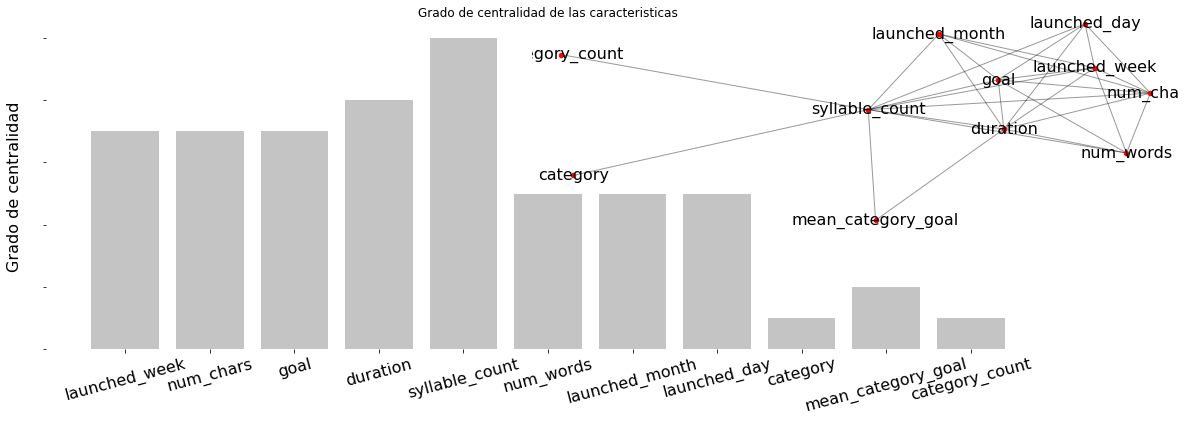

In [9]:
import itertools 
import networkx as nx 
G = nx.Graph()
for tree_in_forest in model1.estimators_:
    doc = {}
    for i,key in enumerate(X_test1.columns):
        doc[key] = tree_in_forest.feature_importances_[i]
    sorted_doc = sorted(doc.items(), key=lambda kv: kv[1], reverse = True)[:10]
    sorted_doc = [c for c in sorted_doc if c[0] != "diff_mean_category_goal"]
    for i, j in itertools.product(sorted_doc, sorted_doc):
        if i == j:
            continue
        if i[1] >= 0.08 or j[1] >= 0.08:
            if np.absolute(i[1] - j[1]) <= 0.05:
                G.add_edge(i[0], j[0])

k = dict(G.degree()).keys()
v = dict(G.degree()).values()

plt.figure(figsize=(18, 6))
ax = plt.subplot(111)
plt.bar(k, v, width=0.80, color='#c4c4c4')
plt.title("Grado de centralidad de las caracteristicas")
plt.ylabel("Grado de centralidad", fontsize=16)
plt.xticks(rotation=15, fontsize=16)
plt.yticks(color="white")

ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()


labels = {}    
for node in G.nodes():
    labels[node] = node
        
plt.axes([0.5, 0.4, 0.5, 0.5])
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_color = "red", node_size=20)
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='black')
nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.show()

- A partir del gráfico anterior, podemos identificar que los nodos de centralidad de grado máximo son: duration, syllable count, goal etc. Desde la perspectiva de la red, significa que si eliminamos estos nodos de la red (nodos de centralidad de alto grado), esto conducirá a la interrupción de la red. Esto es similar a lo que obtuvimos en la gráfica de importancia relativa de características. La conclusión clave de este gráfico es que uno no puede permitirse ignorar estas características mientras optimiza cualquier proyecto de crowdfunding.

## 2. ¿Qué características tienen el mayor impacto en el éxito del proyecto? 
Ya identificamos principalmente cuáles son las características a un nivel muy alto que son relativamente importantes para el resultado del modelo. En esta sección, profundizaremos un poco más y entenderemos qué características tienen el mayor impacto en las predicciones del modelo (en sentido absoluto). Una de las formas de identificar tal comportamiento es utilizar la importancia de la permutación <b>(permutation importance)</b>.

La idea de la importancia de la permutación es muy sencilla. Después de entrenar un modelo, se obtienen los resultados del modelo. Las características más importantes para el modelo son aquellas si los valores de esas características se mezclan aleatoriamente, entonces conducen a mayores caídas en la precisión de los resultados del modelo. Veamos la importancia de la permutación de las características de nuestro modelo.

In [10]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(model1, random_state=1).fit(X_test, y_test)
pi_df = eli5.explain_weights_df(perm, feature_names = X_test.columns.tolist())
pi_df["color"] = pi_df["weight"].apply(lambda x : "blue" if x > 0 else "red")

data = [
    go.Bar(
        orientation = "h",
        y = pi_df.feature[::-1],
        x = pi_df.weight[::-1],
        marker = dict(
            opacity = 0.5,
            color = pi_df.color[::-1]        ),
        error_x = dict( type='data', color="#9fa3a3",
            array=list(pi_df["std"][::-1]),
            visible=True),
        name = 'gastos'
    )
]


layout = go.Layout(title="Permutation Importance", height = 800, margin=dict(l=300))

annotations = []
for i, row in pi_df.iterrows():
    dict(y=row.feature, x=row.weight, text="d",
                                  font=dict(family='Arial', size=14,
                                  color='rgba(245, 246, 249, 1)'),
                                  showarrow=False,)
layout['annotations'] = annotations
fig = go.Figure(data=data, layout = layout)
iplot(fig, filename='base-bar')

Inferencias

- Esta es una gráfica interesante. Podemos observar que las características que se muestran en la parte superior y en azul son las más importantes, ya que si sus valores son aleatorios, el rendimiento del resultado se ve afectado.
- Podemos observar que las características principales son las características que más vimos en la sección de importancia relativa, pero usando este gráfico podemos cuantificar la cantidad de importancia asociada con ellas. Y también obtenga los que son menos importantes, por ejemplo, semana de lanzamiento, si fue fin de semana o no, etc.

Con este método, obtuvimos la importancia de una característica en un sentido más absoluto que en un sentido relativo. Supongamos que nuestro espacio de características forma la mayor parte del universo. Ahora, será interesante trazar tanto la permutación como la importancia relativa de las características y hacer algunas observaciones clave.

In [11]:
imp_df = feature_importances.reset_index().rename(columns = {"index" : "feature"})
combined_df = imp_df.merge(pi_df, on="feature")

trace0 = go.Scatter(
    x = combined_df.importance,
    y = combined_df.weight,
    text = [v.title() if i < 16 else "" for i,v in enumerate(list(combined_df.feature)) ],
    mode='markers+text',
    textposition='top center',
    marker=dict(
        size = 10, color="red", opacity=0.5,
    ),
)

trace1 = go.Scatter(
    x=[0.034, 0.095],
    y=[0.008, 0.020],
    text=['Caracteristicas',
          'Muy importantes caracteristicas'],
    mode='text',
)

data = [trace0]
layout = go.Layout(title = "Caracteristicas : Relativa Importancia VS Importancia Permutada", 
                   showlegend = False, yaxis=dict(title="(Permutada)", showgrid=False),
                   xaxis=dict(title="(Relativa)", showgrid=False))
#                       shapes = [{ 'type': 'circle', 'xref': 'x', 'yref': 'y',
#                                   'x0': 0.024, 'y0': 0.007, 'x1': 0.045, 'y1': 0.001,'opacity': 1.0,
#                                   'line': { 'color': 'rgba(50, 171, 96, 1)', 'dash': 'dot',}},
#                                { 'type': 'rect', 'x0': 0.065, 'y0': 0.019, 'x1': 0.12, 'y1': 0.0002,
#                                 'line': { 'color': 'rgba(128, 0, 128, 1)' , 'dash' : 'dot' }}])
fig = go.Figure(data = data, layout = layout)
iplot(fig, filename='bubblechart-size-ref')

Inferencias

- Se pueden obtener ideas muy interesantes de la gráfica anterior. Hay algunas características que se mostraron más altas en la importancia relativa de las características, pero cuando miramos su importancia de permutaciones, vemos que no son importantes. (Sin embargo, los resultados de la importancia de la permutación no se pueden reproducir exactamente debido a la aleatoriedad, pero cuando tracé esta gráfica por primera vez, observé que la semana y el mes lanzados tenían una alta importancia de características pero una menor importancia de permutación).
- A partir de esta trama, nuevamente podemos observar que nuestra hipótesis es casi cierta, el objetivo del proyecto, la duración, el número de caracteres, el número de palabras son las características más importantes que uno debe tener en cuenta al crear una nueva página de proyecto.

## Presencia de qué palabras clave tienen el mayor impacto en las predicciones.
Utilizando la importancia de la permutación, también podemos evaluar qué palabras clave tienen el mayor impacto en la predicción del modelo. Entrenemos otro modelo que también usa palabras clave utilizadas en el nombre del proyecto y observemos la importancia de la permutación.

In [12]:
def clean_name(x):
    words = x.lower().split()
    cln = [wrd for wrd in words if not wrd[0].isdigit()]
    return " ".join(cln)
projects["cleaned_name"] = projects["name"].apply(lambda x : clean_name(x))

## agregando caracteristicas : top 100
vec = TfidfVectorizer(max_features=100, ngram_range=(1, 2), lowercase=True, stop_words="english", min_df=6)
X = vec.fit_transform(projects['cleaned_name'].values)

## append to original dataframe
vectors_df = pd.DataFrame(X.toarray(), columns=["_"+xx for xx in vec.get_feature_names()])
projects1_df = pd.concat([projects[features], vectors_df], axis=1)

## train the model
X_train, X_test, y_train, y_test = train_test_split(projects1_df, label, test_size = 0.25, random_state = 2)
X_train2, y_train2 = X_train[:15000], y_train[:15000]
X_test2, y_test2 = X_test[:1000], y_test[:1000]
model2 = RandomForestClassifier(random_state=1).fit(X_train2, y_train2)
y_pred = model2.predict(X_test2)



from plotly import tools

perm = PermutationImportance(model2, random_state=1).fit(X_test2, y_test2)
pi_df = eli5.explain_weights_df(perm, feature_names = X_test2.columns.tolist(), feature_filter=lambda x: x[0] == '_')
pi_df["feature"] = pi_df["feature"].apply(lambda x : x[1:])
highs = pi_df[pi_df.weight >= 0.001]
med = pi_df[(pi_df.weight > -0.0005) & (pi_df.weight < 0.001)]
lows = pi_df[pi_df.weight <= -0.0005]

trace1 = go.Bar(
        orientation = "h",
        y = highs.feature[::-1],
        x = highs.weight[::-1],
        marker = dict(opacity = 0.4, color = "green" ), error_x = dict(type='data', color="#9fa3a3", array=list(highs["std"][::-1]), visible=True))
trace2 = go.Bar(
        orientation = "h",
        y = med.feature[:15][::-1],
        x = med.weight[:15][::-1],
        marker = dict(opacity = 0.4, color = "yellow"), error_x = dict(type='data', color="#9fa3a3", array=list(med["std"][:15][::-1]), visible=True))
trace3 = go.Bar(
        orientation = "h",
        y = lows.feature,
        x = lows.weight,
        marker = dict(opacity = 0.4, color = "red"), error_x = dict(type='data', color="#9fa3a3", array=list(lows["std"][::-1]), visible=True))

ttls = ["Impacto Positivo","", "Moderado" ,"", "Impacto Negativo"]
fig = tools.make_subplots(rows=1, cols=5, print_grid=False, subplot_titles = ttls)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 3)
fig.append_trace(trace3, 1, 5)

fig['layout'].update(showlegend=False, title='Impacto de las palabras usadas en la descripcion - Permutation Importance')
iplot(fig, filename='simple-subplot-with-annotations')

Inferencias

- Desde el primer gráfico, podemos observar que hay ciertas palabras clave que, cuando se usan en el nombre del proyecto, probablemente aumenten la probabilidad de éxito de un proyecto. Ejemplo: "project", "film", and "community". Mientras que, por otro lado, es probable que palabras clave como "game", "series", "dream" generen menos atracción. Esto implica que los proyectos de crowdfunding relacionados con juegos o entretenimiento como "series" o "dream" pueden no tener mucho éxito en comparación con los relacionados con el arte, el diseño, etc.


## 3. ¿Cómo los cambios en las características conducen a cambios en el resultado del modelo?

Hasta ahora solo hemos hablado de las características más o menos importantes de un conjunto de muchas características. Por ejemplo, observamos que el objetivo del proyecto, la duración del proyecto, la cantidad de caracteres utilizados, etc. son algunas de las características importantes relacionadas con el éxito del proyecto. Ahora veremos cuáles son los valores o rangos de características específicos que conducen al éxito o al fracaso del proyecto. Específicamente, observaremos cómo la realización de cambios como aumentar o disminuir los valores afecta los resultados del modelo. Estos efectos pueden obtenerse trazando las gráficas de dependencia parcial de diferentes características.

cols_of_interest = ['num_words', 'num_chars', 'syllable_count',
                    'duration', 'launched_month', 'launched_day',
                    'category_count', 'main_category_count']
                    
- Posibles campos sobre los cuales realizar la verificacion

### Sobre el campo Nombre del proyecto

findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans.


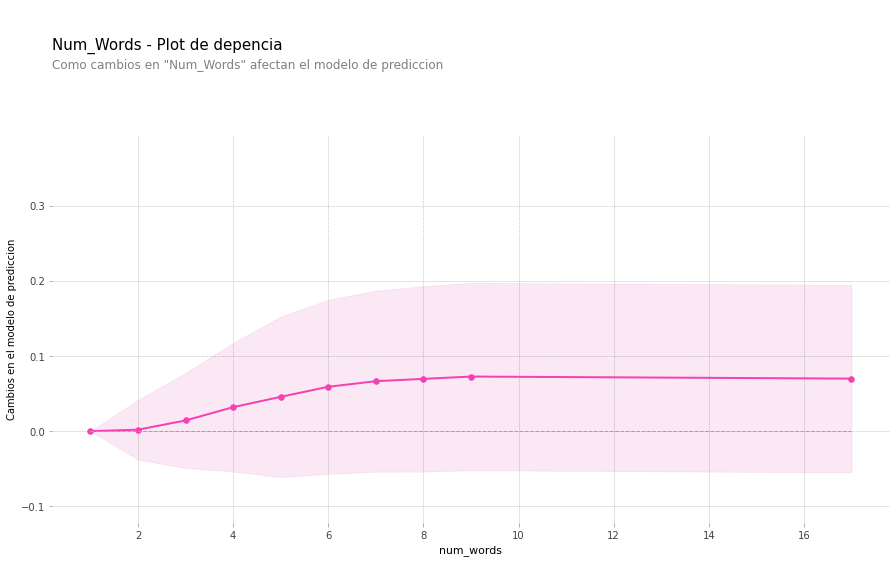

In [13]:
def _plot_pdp(feature, pdp_color, fill_color):
    plot_params = {
        'title': feature.title() + ' - Plot de depencia',
        'title_fontsize': 15,
        'subtitle': 'Como cambios en "%s" afectan el modelo de prediccion' % feature.title(),
        'subtitle_fontsize': 12,
        'font_family': 'Arial',
        'xticks_rotation': 0,
        'line_cmap': 'cool',
        'zero_color': '#a2a5a0',
        'zero_linewidth': 1.0,
        'pdp_linewidth': 2.0,
        'fill_alpha': 0.25,
        'markersize': 5.5,
        'pdp_hl_color': 'green',
        'pdp_color': pdp_color,
        'fill_color': fill_color,

    }
    pdp_goals = pdp.pdp_isolate(model=model1, dataset=X_test1, model_features=X_test1.columns, feature=feature)
    pdp.pdp_plot(pdp_goals, feature, plot_params = plot_params)
    plt.ylabel("Cambios en el modelo de prediccion");
    plt.show();
    
cols_of_interest = ['num_words', 'num_chars', 'syllable_count',
                    'duration', 'launched_month', 'launched_day',
                    'category_count', 'main_category_count']

_plot_pdp(cols_of_interest[0], "#f442b3", "#efaad6")

- Observamos que los proyectos que tienen menor número de palabras (<= 3) en el nombre no muestran ninguna mejora en el éxito del modelo. Sin embargo, si uno comienza a aumentar el número de palabras en el nombre del proyecto, la mejora del modelo correspondiente también aumenta linealmente. Para todos los proyectos que tienen más de 10 palabras en el nombre, el modelo se satura y muestra predicciones similares. Por lo tanto, el límite de palabras ideal es de alrededor de 7 a 10.

### Sobre el campo Duracion y dia de lanzamiento (DateTime)

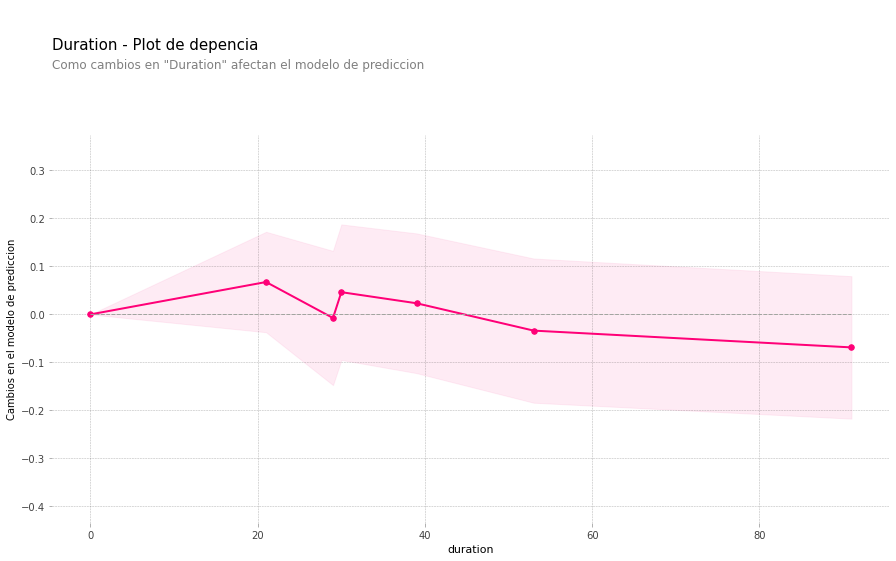

In [14]:
_plot_pdp(cols_of_interest[3], "#ff0077", "#fcb3d5")

- Para una duración de proyecto más corta (menos de 20 días), las posibilidades de que el proyecto tenga éxito son mayores. Sin embargo, si se aumenta la duración de un proyecto a 60-90 días, es menos probable que logre su objetivo.

### Sobre el campo categoria principal

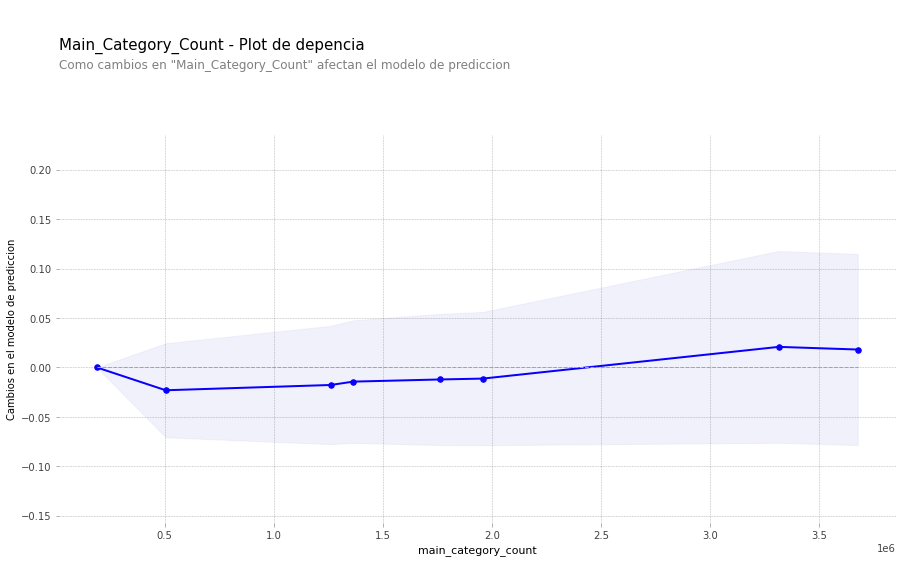

In [15]:
_plot_pdp(cols_of_interest[7], "#0800ff", "#cac9f2")

- Según la definición de la característica, el recuento de categorías es una característica que actúa como proxy de la popularidad de una categoría de proyecto. Por ejemplo, si en la categoría Viajes se publica una gran cantidad de proyectos, su category_count será mayor, por lo que es una categoría popular en Kickstarter. Por otro lado, si en la categoría Entretenimiento, muy raramente alguien agrega un proyecto, su category_count será menor y también lo será su popularidad. A partir de la trama, podemos observar que las posibilidades de que un proyecto tenga éxito serán mayores si pertenece a una categoría popular. También es válido para la categoría principal.

## 4. Entender las decisiones tomadas por el modelo.
- SHAP (SHapley Additive exPlanations): es un enfoque teórico de juegos para explicar el resultado de cualquier modelo de aprendizaje automático. Conecta la asignación de crédito óptima con explicaciones locales utilizando los valores clásicos de Shapley de la teoría de juegos y sus extensiones relacionadas.

Finalmente, hacemos las predicciones finales de nuestro modelo y las interpretamos. Para este propósito usaremos valores SHAP que son el promedio de contribuciones marginales de valores de características individuales en todas las coaliciones posibles. Tratemos de entender esto en términos simples. Considere un proyecto aleatorio del conjunto de datos con las siguientes características:

- El título contiene 8 palabras
- El título contiene "aprendizaje automático"
- El objetivo del proyecto es de 10000 dólares estadounidenses
- El proyecto se lanza en un día laborable

El modelo entrenado predice que es probable que este proyecto tenga éxito con una probabilidad del 75%. Pero, alguien hace la pregunta: ¿Por qué este proyecto tiene una probabilidad de éxito del 75% y no del 95%? Para responder a esta pregunta, obtenemos los valores de forma para la predicción realizada por el modelo para este proyecto. Los valores de Shap indican la cantidad de aumento o disminución en el valor de resultado del modelo del valor promedio de las predicciones en todo el conjunto de datos. 
Por ejemplo: 
- El valor de predicción promedio para este proyecto habría sido del 45% sin ningún modelo.
- Debido a la presencia de 8 palabras clave en el título del proyecto, la probabilidad de éxito aumenta al 60%.
- Dado que el título contiene el texto "aprendizaje automático", la probabilidad de éxito aumenta aún más al 88%.
- Dado que el proyecto se lanza en un día laborable, la probabilidad de éxito aumenta entre un 2% y un 90%
- Sin embargo, dado que el objetivo del proyecto es demasiado alto (en comparación con el promedio del universo), la probabilidad de éxito se reduce del 90% al 75%.

In [7]:
preds = model1.predict(X_test1)
dict(Counter(preds))

{1: 2298, 0: 4236}

- En una muestra de alrededor de 6500 proyectos de crowdfunding, el Modelo predice que alrededor de 4200 fallarán y solo alrededor de 2300 tendrán éxito. Ahora, nos interesa comprender qué está impulsando el éxito y el fracaso de estos proyectos. Grafiquemos los efectos de las características individuales en algunas de estas predicciones para que tengan sentido.

In [12]:
import shap 
shap.initjs()
data_for_prediction = X_test.iloc[1]
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction, plot_cmap=["#f04e4e","#6677f9"])

- Para este proyecto en particular, el valor de predicción se incrementa a 0.58 desde el valor base de 0.4178. Esto implica que la presencia de ciertas características y sus valores correspondientes en este proyecto aumenta las probabilidades de éxito. Por ejemplo, la duración es 44, la cantidad de caracteres en el nombre del proyecto es 27 y la diferencia entre la cantidad objetivo y la cantidad objetivo promedio de la categoría es de aproximadamente 50K. Estas características aumentan la probabilidad.

In [10]:
shap.initjs()
data_for_prediction = X_test.iloc[10]
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction, plot_cmap=["#f79d2e","#812df7"])

- Para este proyecto, una gran duración, la presencia de una categoría en particular disminuye las posibilidades de manera significativa. No muchas caracteristicas y los valores de las caracteristicas pueden aumentar las posibilidades de éxito del proyecto.

Ahora, podemos agregar los valores de forma para cada característica para cada predicción realizada por el modelo. Esto ayuda a comprender un efecto agregado general de las características del modelo. Hagamos la trama de resumen.

In [ ]:
X_test_s = X_test.head(1000)
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test_s)
shap.summary_plot(shap_values[1], X_test_s)

- Podemos observar que los valores de SHAP son más altos para el mismo conjunto de características que vimos en importancia relativa de característica e importancia de permutación. Esto confirma que las características que influyen en gran medida en el éxito del proyecto están relacionadas con características del proyecto, como la duración o el objetivo.

# Conclusion

>> 
Después de aplicar estas diferentes técnicas, entendimos que existen ciertos factores que aumentan o disminuyen las posibilidades de que un proyecto logre recaudar fondos. Tanto desde la perspectiva del propietario del proyecto como de la empresa, es importante establecer los valores óptimos del objetivo del proyecto y la duración. Es posible que una gran duración o una cantidad muy grande no sean completamente exitosas. Al mismo tiempo, es importante elegir el número correcto de palabras y caracteres en el nombre del proyecto. Por ejemplo, un proyecto que tenga muy pocas palabras y caracteres o una gran cantidad de palabras puede volverse menos intuitivo y menos explicativo. De manera similar, la categoría de proyecto también juega un papel fundamental. Habrá algunas categorías en la plataforma en las que el número total de proyectos es muy grande, estas son las llamadas categorías populares. Las posibilidades pueden ser mayores si el proyecto se publica en una categoría popular en lugar de en una categoría rara.